# Loading & Preprocessing of the dataset

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === File paths ===
gdp_path = "API_NY.GDP.MKTP.KD.ZG_DS2_en_csv_v2_23243.csv"
fdi_path = "API_BX.KLT.DINV.CD.WD_DS2_en_csv_v2_204.csv"

# === Common country codes ===
country_codes = ["EUU", "LMY", "WLD", "BGR", "POL", "RUS", "USA", "UGA"]

# === Year ranges ===
gdp_years = [str(y) for y in range(1993, 2012)]   
fdi_years_full = [str(y) for y in range(1992, 2012)]  
fdi_growth_years = [str(y) for y in range(1993, 2012)]  # resulting FDI growth years

def load_worldbank_csv(path, years):
    
    with open(path, "r", encoding="utf-8-sig") as f:
        lines = f.readlines()
    header_line = next(i for i, line in enumerate(lines) if line.startswith('"Country Name"'))
    df = pd.read_csv(path, skiprows=header_line)
    
    # Keep only relevant columns
    year_cols = [col for col in df.columns if col in years]
    keep_cols = ["Country Name", "Country Code", "Indicator Name"] + year_cols
    df = df[keep_cols]
    
    # Filter by country codes
    df = df[df["Country Code"].isin(country_codes)]
    return df

# === Load GDP and FDI data ===
gdp_df = load_worldbank_csv(gdp_path, gdp_years)
fdi_df = load_worldbank_csv(fdi_path, fdi_years_full)

# === Compute FDI Growth === For calculating rate of growth of FDI
fdi_growth_df = fdi_df.copy()

for y in fdi_growth_years:
    prev_y = str(int(y) - 1)
    if prev_y in fdi_df.columns:
        fdi_growth_df[y] = (
            (fdi_df[y].astype(float) - fdi_df[prev_y].astype(float))
            / fdi_df[prev_y].astype(float)
        ) * 100
    else:
        fdi_growth_df[y] = np.nan

# Keep only metadata + computed FDI growth columns
keep_cols_growth = ["Country Name", "Country Code"] + fdi_growth_years
fdi_growth_df = fdi_growth_df[keep_cols_growth]

gdp_df = gdp_df.rename(columns={col: f"GDP_{col}" for col in gdp_years})
fdi_growth_df = fdi_growth_df.rename(columns={col: f"FDI_{col}" for col in fdi_growth_years})

merged_df = pd.merge(
    gdp_df,
    fdi_growth_df,
    on=["Country Name", "Country Code"],
)

merged_df.to_csv("merged_gdp_fdigrowth_data.csv", index=False)
print("✅ Merged GDP + FDI Growth data saved to 'merged_gdp_fdigrowth_data.csv'")
print("Columns:", merged_df.columns.tolist())



✅ Merged GDP + FDI Growth data saved to 'merged_gdp_fdigrowth_data.csv'
Columns: ['Country Name', 'Country Code', 'Indicator Name', 'GDP_1993', 'GDP_1994', 'GDP_1995', 'GDP_1996', 'GDP_1997', 'GDP_1998', 'GDP_1999', 'GDP_2000', 'GDP_2001', 'GDP_2002', 'GDP_2003', 'GDP_2004', 'GDP_2005', 'GDP_2006', 'GDP_2007', 'GDP_2008', 'GDP_2009', 'GDP_2010', 'GDP_2011', 'FDI_1993', 'FDI_1994', 'FDI_1995', 'FDI_1996', 'FDI_1997', 'FDI_1998', 'FDI_1999', 'FDI_2000', 'FDI_2001', 'FDI_2002', 'FDI_2003', 'FDI_2004', 'FDI_2005', 'FDI_2006', 'FDI_2007', 'FDI_2008', 'FDI_2009', 'FDI_2010', 'FDI_2011']


# Visulalisation of the dataset used


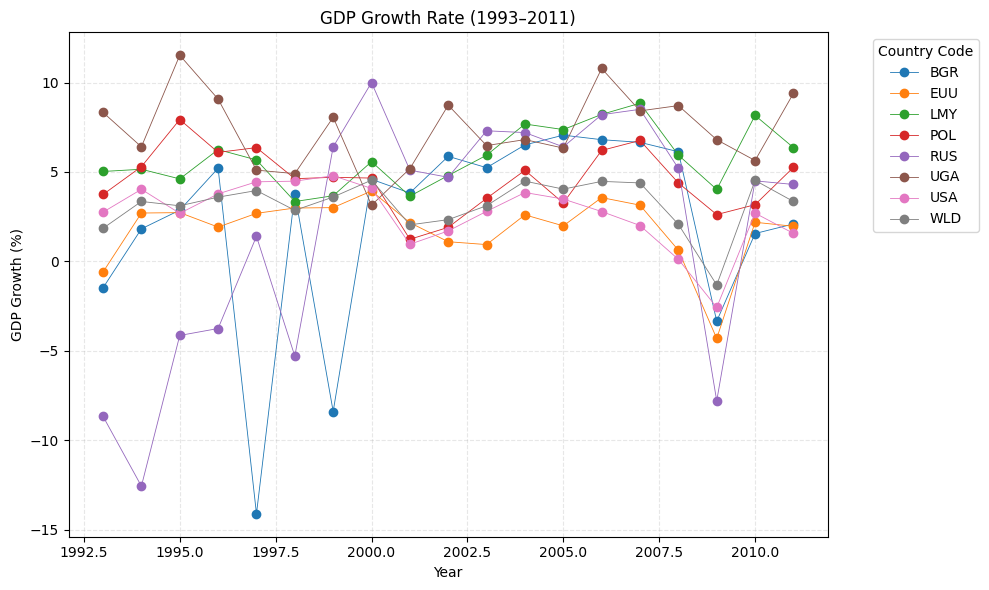

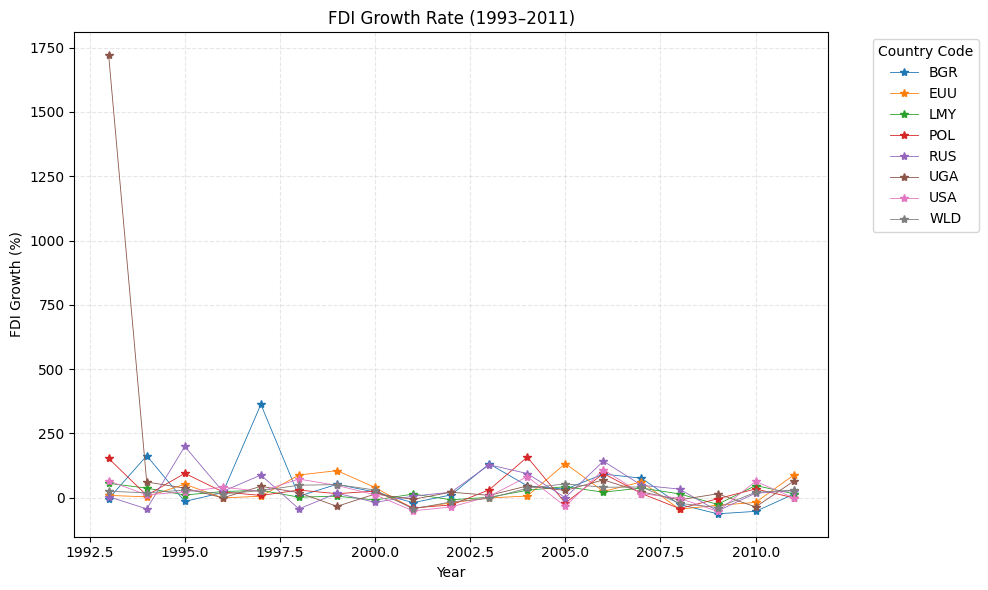

In [3]:

# Extract year columns
gdp_cols = [col for col in merged_df.columns if col.startswith("GDP_")]
fdi_growth_cols = [col for col in merged_df.columns if col.startswith("FDI_")]

# Create numeric year labels
gdp_years_num = [int(c.replace("GDP_", "")) for c in gdp_cols]
fdi_years_num = [int(c.replace("FDI_", "")) for c in fdi_growth_cols]

# --- Plot GDP Growth ---
plt.figure(figsize=(10, 6))
for _, row in merged_df.iterrows():
    plt.plot(
        gdp_years_num,
        row[gdp_cols].astype(float),
        marker='o',
        linewidth=0.6,
        label=row["Country Code"]
    )
plt.title("GDP Growth Rate (1993–2011)")
plt.xlabel("Year")
plt.ylabel("GDP Growth (%)")
plt.legend(title="Country Code", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig('gdp.png')

# --- Plot FDI Growth ---
plt.figure(figsize=(10, 6))
for _, row in merged_df.iterrows():
    plt.plot(
        fdi_years_num,
        row[fdi_growth_cols].astype(float),
        marker='*',
        linewidth=0.6,
        label=row["Country Code"]
    )
plt.title("FDI Growth Rate (1993–2011)")
plt.xlabel("Year")
plt.ylabel("FDI Growth (%)")
plt.legend(title="Country Code", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig("fdirate.png")


# Transformation of discrete data to continuous 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import eig
from collections import Counter

# -----------------------------
# Utility basis & fitting code
# -----------------------------
def legendre_polynomial(x, k):
    if k == 0:
        return np.ones_like(x)
    elif k == 1:
        return x
    else:
        Pkm1 = legendre_polynomial(x, k-1)
        Pkm2 = legendre_polynomial(x, k-2)
        return ((2*(k-1)+1) * x * Pkm1 - (k-1) * Pkm2) / k

def legendre_basis_function_vectorized(t_array, k, a=-1.0, b=1.0):
    """
    Return values of the orthonormalized Legendre polynomial of degree k
    evaluated at t_array (t_array in [a, b]). We map t -> x in [-1,1].
    """
    t = np.asarray(t_array, dtype=float)
    x = (2*t - (b + a)) / (b - a)   # map [a,b] -> [-1,1]
    p_k = legendre_polynomial(x, k)
    # orthonormalization factor used in the paper: sqrt((2k+1)/2)
    return np.sqrt((2*k + 1) / 2.0) * p_k

def build_phi_matrix_legendre(time_points, K, a=-1.0, b=1.0):
    """
    time_points: array-like of times (in the original numeric scale)
    we assume times are already in [a,b] or we map them via formula above
    returns Phi (J x (K+1))
    """
    J = len(time_points)
    Phi = np.zeros((J, K+1), dtype=float)
    for k in range(K+1):
        Phi[:, k] = legendre_basis_function_vectorized(time_points, k, a, b)
    return Phi

def fit_least_squares(Phi, y):
    """Return coefficients alpha_hat solving (Phi'Phi) alpha = Phi'y with robust fallback."""
    try:
        coeffs = np.linalg.solve(Phi.T @ Phi, Phi.T @ y)
    except np.linalg.LinAlgError:
        coeffs = np.linalg.pinv(Phi) @ y
    return coeffs



# Normalisation, Bayesian Information Criterion(BIC) and Selection of K

In [5]:
def bic_paper(discrete_data, fitted_values, num_coefficients):
    """
    Paper's BIC (as printed in the PDF):
    BIC(y) = ln( e'e / 2 ) + (K1 + 1) * ( ln J* / J* )
    where e'e = sum squared residuals, J* = number of observations
    """
    residuals = discrete_data - fitted_values
    ssr = np.sum(residuals**2)
    J = len(discrete_data)

    # guard against zero SSR
    if ssr <= 0:
        return -np.inf  # perfect fit -> extremely small BIC (choose this K)
    bic_val = np.log(ssr / 2.0) + (num_coefficients) * (np.log(J) / J)
    return bic_val

# Parameters
N_regions = 8
region_labels = ["EUU", "LMY", "WLD", "BGR", "POL", "RUS", "UGA", "USA"]

# years for GDP (1993-2011)
years = np.arange(1993, 2012)  # 19 points
J_star = len(years)

# Time mapping to [-1, 1] for Legendre basis as per paper:
time_grid_original = years.copy()
# Map these year values linearly to [-1,1]
t_min, t_max = time_grid_original.min(), time_grid_original.max()
time_mapped = (2*time_grid_original - (t_max + t_min)) / (t_max - t_min)  # in [-1,1]

# Load merged CSV created earlier (GDP_1993..GDP_2011 and FDI_GROWTH_1993..FDI_GROWTH_2011)
df = pd.read_csv("merged_gdp_fdigrowth_data.csv")

# Prepare containers
all_alpha = []  # will hold coefficient vectors for GDP (Y)
all_beta = []   # will hold coefficient vectors for FDI_GROWTH (X)
Ks_y = []       # selected K per region for Y
Ks_x = []       # selected K per region for X

max_K = 5  # this need to be greater than 2 for the datasets we have used here 

# For each region: extract, center and select K by BIC
for code in region_labels:
    row = df[df["Country Code"] == code]
    if row.empty:
        raise ValueError(f"No data found for region code {code}")
    # Extract GDP time series (1993-2011)
    gdp_cols = [f"GDP_{yr}" for yr in years]
    fdi_growth_cols = [f"FDI_{yr}" for yr in years]
    # Convert to numeric and flatten
    gdp_vals = row[gdp_cols].astype(float).values.flatten()
    fdi_vals = row[fdi_growth_cols].astype(float).values.flatten()


    # Center the series (important per paper)
    gdp_vals = gdp_vals - np.nanmean(gdp_vals)
    fdi_vals = fdi_vals - np.nanmean(fdi_vals)

    # SELECT K for GDP (Y) using BIC
    best_bic_y = np.inf
    best_K_y = 0
    best_coeffs_y = None
    for Kc in range(0, max_K+1):
        Phi = build_phi_matrix_legendre(time_mapped, Kc, a=-1.0, b=1.0)  # J x (Kc+1)
        coeffs = fit_least_squares(Phi, gdp_vals)
        fitted = Phi @ coeffs
        bic_val = bic_paper(gdp_vals, fitted, num_coefficients=(Kc+1))
        if bic_val < best_bic_y:
            best_bic_y = bic_val
            best_K_y = Kc
            best_coeffs_y = coeffs
    Ks_y.append(best_K_y)

    # SELECT K for FDI_GROWTH (X) using BIC
    best_bic_x = np.inf
    best_K_x = 0
    best_coeffs_x = None
    for Kc in range(0, max_K+1):
        Psi = build_phi_matrix_legendre(time_mapped, Kc, a=-1.0, b=1.0)
        coeffs_x = fit_least_squares(Psi, fdi_vals)
        fitted_x = Psi @ coeffs_x
        bic_val_x = bic_paper(fdi_vals, fitted_x, num_coefficients=(Kc+1))
        if bic_val_x < best_bic_x:
            best_bic_x = bic_val_x
            best_K_x = Kc
            best_coeffs_x = coeffs_x
    Ks_x.append(best_K_x)

    # store best coeffs for now (we will re-fit with modal K later to ensure same K)
    all_alpha.append(best_coeffs_y)
    all_beta.append(best_coeffs_x)

print("Per-region selected Ks for GDP (Y):", Ks_y)
print("Per-region selected Ks for FDI_GROWTH (X):", Ks_x)

# Modal K across regions (take most common)
mode_y = Counter(Ks_y).most_common(1)[0][0]
mode_x = Counter(Ks_x).most_common(1)[0][0]
print(f"Modal K across regions -> K_y = {mode_y}, K_x = {mode_x}")


Per-region selected Ks for GDP (Y): [0, 1, 0, 0, 5, 2, 0, 1]
Per-region selected Ks for FDI_GROWTH (X): [0, 0, 0, 0, 0, 0, 5, 0]
Modal K across regions -> K_y = 0, K_x = 0


# Estimation of Covariance Matrices 

In [6]:

# As per paper they found K1 = K2 = 2.
mode_y = 2
mode_x = 2

# Re-fit all series using the modal K to build A and B matrices
K_y_final = mode_y
K_x_final = mode_x
num_coeffs_y = K_y_final + 1
num_coeffs_x = K_x_final + 1

A = np.zeros((N_regions, num_coeffs_y))
B = np.zeros((N_regions, num_coeffs_x))

for idx, code in enumerate(region_labels):
    row = df[df["Country Code"] == code]
    gdp_vals = row[[f"GDP_{yr}" for yr in years]].astype(float).values.flatten()
    fdi_vals = row[[f"FDI_{yr}" for yr in years]].astype(float).values.flatten()


    Phi = build_phi_matrix_legendre(time_mapped, K_y_final, a=-1.0, b=1.0)
    Psi = build_phi_matrix_legendre(time_mapped, K_x_final, a=-1.0, b=1.0)

    alpha_hat = fit_least_squares(Phi, gdp_vals)
    beta_hat = fit_least_squares(Psi, fdi_vals)

    A[idx, :len(alpha_hat)] = alpha_hat
    B[idx, :len(beta_hat)] = beta_hat

# Center coefficient matrices A and B (important)
A = A - A.mean(axis=0)
B = B - B.mean(axis=0)

# Estimate covariance matrices as in paper (1/N) A' A, etc.
Sigma_11_hat = (1.0 / N_regions) * (A.T @ A)
Sigma_22_hat = (1.0 / N_regions) * (B.T @ B)
Sigma_12_hat = (1.0 / N_regions) * (A.T @ B)
Sigma_21_hat = Sigma_12_hat.T

print("\nSigma_11_hat shape:", Sigma_11_hat.shape)
print("Sigma_22_hat shape:", Sigma_22_hat.shape)
print("Sigma_12_hat shape:", Sigma_12_hat.shape)

# Check positive-definiteness (or at least invertibility)
# Use pseudo-inverse fallback if needed
try:
    inv_Sigma_11 = np.linalg.inv(Sigma_11_hat)
except np.linalg.LinAlgError:
    inv_Sigma_11 = np.linalg.pinv(Sigma_11_hat)
    print("Warning: used pseudo-inverse for Sigma_11_hat")

try:
    inv_Sigma_22 = np.linalg.inv(Sigma_22_hat)
except np.linalg.LinAlgError:
    inv_Sigma_22 = np.linalg.pinv(Sigma_22_hat)
    print("Warning: used pseudo-inverse for Sigma_22_hat")




Sigma_11_hat shape: (3, 3)
Sigma_22_hat shape: (3, 3)
Sigma_12_hat shape: (3, 3)


# Calculation of Weight Functions


Canonical correlations (rho): [0.96708505 0.86865285 0.4598895 ]
Number of canonical pairs: 3


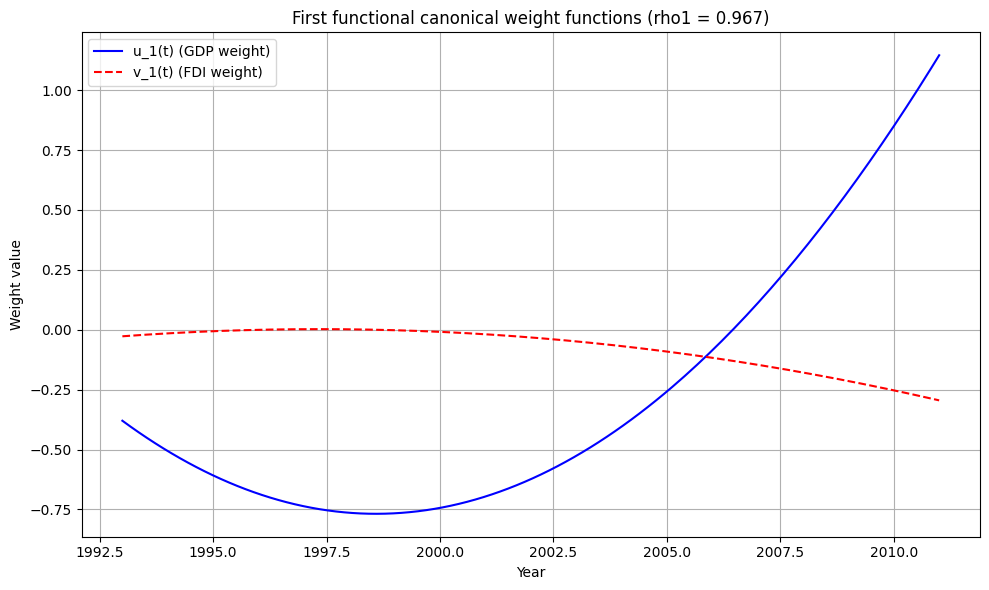

In [7]:
C = inv_Sigma_11 @ Sigma_12_hat
D = inv_Sigma_22 @ Sigma_21_hat

# Solve eigenproblems for CD and DC
eigvals_CD, eigvecs_CD = eig(C @ D)
eigvals_DC, eigvecs_DC = eig(D @ C)

# Real parts and non-negative enforcement (numerical)
rho2 = np.real(eigvals_CD)
rho2[rho2 < 0] = 0.0
sort_idx = np.argsort(rho2)[::-1]
rho = np.sqrt(rho2[sort_idx])

# canonical weights (corresponding eigenvectors)
U_vecs = np.real(eigvecs_CD[:, sort_idx])
V_vecs = np.real(eigvecs_DC[:, sort_idx])

# Normalize weight vectors so u' Sigma_11 u = 1, v' Sigma_22 v = 1
for k in range(min(U_vecs.shape[1], V_vecs.shape[1])):
    uk = U_vecs[:, k]
    vk = V_vecs[:, k]
    denom_u = np.sqrt(uk.T @ Sigma_11_hat @ uk)
    denom_v = np.sqrt(vk.T @ Sigma_22_hat @ vk)
    if denom_u > 1e-12:
        U_vecs[:, k] = uk / denom_u
    if denom_v > 1e-12:
        V_vecs[:, k] = vk / denom_v

print("\nCanonical correlations (rho):", rho)
print("Number of canonical pairs:", min(num_coeffs_y, num_coeffs_x))

# Reconstruct functional weight functions on dense grid for plotting
time_dense_original = np.linspace(t_min, t_max, 200)
time_dense_mapped = (2*time_dense_original - (t_max + t_min)) / (t_max - t_min)

Phi_dense = build_phi_matrix_legendre(time_dense_mapped, K_y_final, a=-1.0, b=1.0)
Psi_dense = build_phi_matrix_legendre(time_dense_mapped, K_x_final, a=-1.0, b=1.0)

# First pair plotting
kplot = 0
u_k_t = Phi_dense @ U_vecs[:, kplot]
v_k_t = Psi_dense @ V_vecs[:, kplot]

plt.figure(figsize=(10,6))
plt.plot(time_dense_original, u_k_t, label="u_1(t) (GDP weight)", color='blue')
plt.plot(time_dense_original, v_k_t, label="v_1(t) (FDI weight)", color='red', linestyle='--')
plt.title(f"First functional canonical weight functions (rho1 = {rho[0]:.3f})")
plt.xlabel("Year")
plt.ylabel("Weight value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("cca_weight.png")

# Canonical Variables and its visualisation


U_scores (first canonical variable) per region:
EUU 0.36112487353382566
LMY -0.5204441020735903
WLD 0.043004243747574465
BGR 1.3755871190445657
POL -0.6591479893619745
RUS 1.52306487489845
UGA -1.651708474889759
USA -0.4714805448990898

V_scores (first canonical variable) per region:
EUU -0.3323005582097972
LMY 0.09739992179118148
WLD 0.828068536308995
BGR 1.343041648276456
POL 0.3101779085860223
RUS -1.9121996675681676
UGA -1.0564961043871524
USA 0.7223083152024635


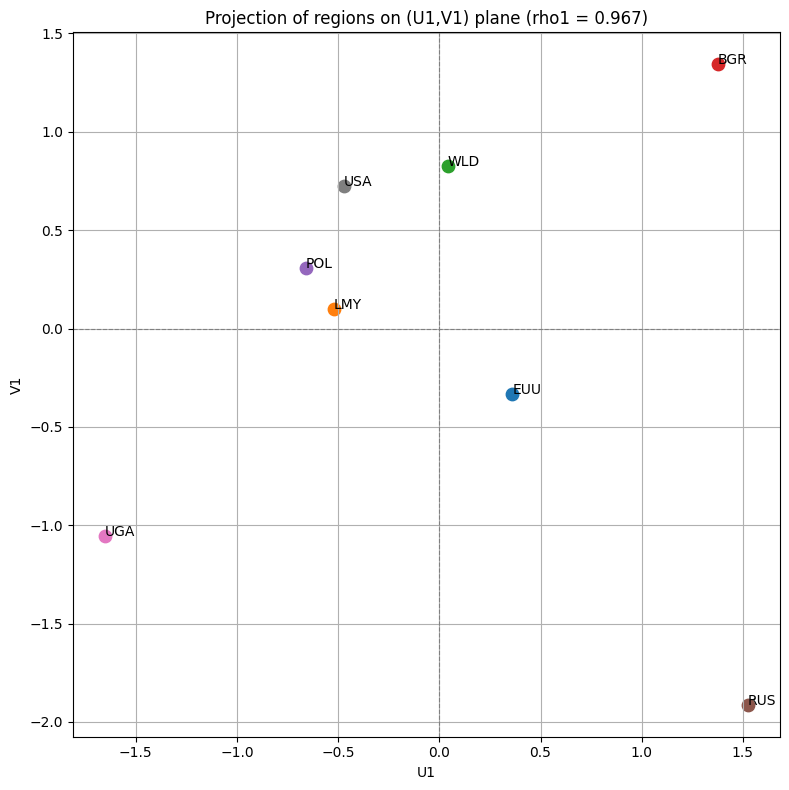

In [8]:

# Compute canonical variables U and V for each region
num_pairs = min(num_coeffs_y, num_coeffs_x)
U_scores = (A @ U_vecs[:, :num_pairs])
V_scores = (B @ V_vecs[:, :num_pairs])

print("\nU_scores (first canonical variable) per region:")
for i, code in enumerate(region_labels):
    print(code, U_scores[i,0])

print("\nV_scores (first canonical variable) per region:")
for i, code in enumerate(region_labels):
    print(code, V_scores[i,0])

# Scatter plot regions on (U1,V1)
plt.figure(figsize=(8,8))
for i, code in enumerate(region_labels):
    plt.scatter(U_scores[i,0], V_scores[i,0], s=80)
    plt.text(U_scores[i,0]+1e-6, V_scores[i,0]+1e-6, code)
plt.xlabel("U1")
plt.ylabel("V1")
plt.title(f"Projection of regions on (U1,V1) plane (rho1 = {rho[0]:.3f})")
plt.grid(True)
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.savefig("cca_projection.png")
